### Machine Learning with Big Data
## Part 2: Convolutional Neural Networks

# 0.7 - Data Augmentation

**Group:** MLBD_Deventer 4   
**Students:** Mathijs Pattipeilohy (512391), Emin Fikret (511275)

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from joblib import load

2025-10-25 16:48:07.124089: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 16:48:07.149558: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-25 16:48:07.345997: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-25 16:48:08.644005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SEED = 42
EPOCHS = 10
BATCH = 32

tf.keras.utils.set_random_seed(SEED)

In [3]:
ARTIFACTS_DIR = "../artifacts"
MODEL_NAME = "cnn_data_augmentation"

INPUT_FILE = os.path.join(ARTIFACTS_DIR, "images_tuple.joblib")

LOG_DIR   = os.path.join(ARTIFACTS_DIR, "logs", f"{MODEL_NAME}")
MODEL_FILE = os.path.join(ARTIFACTS_DIR, f"{MODEL_NAME}.keras")
CKPT_FILE  = os.path.join(ARTIFACTS_DIR, f"best_{MODEL_NAME}.keras")

In [4]:
(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    classes
) = load(INPUT_FILE)

num_classes = len(classes)
print("Classes:", classes)
print("Train shape:", X_train.shape, y_train.shape)

Classes: ['az', 'dobro', 'estb', 'frbtb', 'ize', 'jatb', 'ljudie', 'nasb', 'sa', 'sta', 'ukb', 'vede']
Train shape: (900, 128, 128, 4) (900, 12)


### Recap

In the previous version, we implemented early stopping, which prevented overfitting by restoring the best model weights once the validation loss stopped improving.  

To improve generalization, we now add data augmentation by randomly transforming images to simulate natural variations.

## Model: Data Augmentation

Data augmentation helps the model generalize better by creating new, slightly modified versions of the training images.
This exposes the network to more visual variation without needing additional data.

The data augmentation techniques we used are:

- RandomRotation slightly rotates the images. For example, some people write with different hands, which can change the angle of the written symbol. Random rotation helps the model handle these small orientation differences.

- RandomTranslation shifts images slightly up, down, left, or right, making the model less sensitive to where the symbol appears in the image.

Some augmentations can actually make the model perform worse, depending on the type of data.
In our case, since we are predicting symbols, using random horizontal or vertical flips would not make sense.
If our dataset contained objects like cats or dogs, we could use RandomFlip("horizontal") to simulate mirrored views.
However, Glagolitic symbols can look different when flipped or heavily rotated, so such transformations could confuse the model instead of improving it.

In [5]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.Rescaling(1.0 / 255), # min-max scale rbg values
    
    tf.keras.layers.Conv2D(
        32, (3,3), 
        activation="relu",
        padding="same", # add zeros around the edges
    ), # learns low-level features, like edges
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25), # low regularization
    
    tf.keras.layers.Conv2D(
        64, (3,3), 
        activation="relu",
        padding="same", # add zeros around the edges
    ), # learns higher-lever combinations, like shapes
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Dropout(0.25), # mid regularization
    
    tf.keras.layers.Flatten(), # turns 2d features into 1d vector
    tf.keras.layers.Dropout(0.5), # high regularization
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(), # variation of gradient descent
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # we could have just used accuracy, 
    # it would have fallen back to categorical accuracy
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (None, 128, 128, 4)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 128, 128, 4)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 4)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │       786,444 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,124 (3.08 MB)

 Trainable params: 806,124 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    # if val_loss does not get better after 3 epochs, 
    # stop training and get the best model weights
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    ),
    # save best model
    tf.keras.callbacks.ModelCheckpoint(
        CKPT_FILE, monitor="val_categorical_accuracy", save_best_only=True
    )
]

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(X_val, y_val),
    # or we could have used "validation_set" param
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/10


2025-10-25 16:48:11.617352: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 235929600 exceeds 10% of free system memory.


29/29 - 10s - 348ms/step - categorical_accuracy: 0.2856 - loss: 2.9534 - val_categorical_accuracy: 0.7248 - val_loss: 0.8184
Epoch 2/10
29/29 - 7s - 254ms/step - categorical_accuracy: 0.7433 - loss: 0.7652 - val_categorical_accuracy: 0.8333 - val_loss: 0.4652
Epoch 3/10
29/29 - 10s - 356ms/step - categorical_accuracy: 0.8200 - loss: 0.5720 - val_categorical_accuracy: 0.8721 - val_loss: 0.3417
Epoch 4/10
29/29 - 8s - 274ms/step - categorical_accuracy: 0.8300 - loss: 0.5000 - val_categorical_accuracy: 0.8837 - val_loss: 0.3619
Epoch 5/10
29/29 - 8s - 287ms/step - categorical_accuracy: 0.8533 - loss: 0.4525 - val_categorical_accuracy: 0.8992 - val_loss: 0.3336
Epoch 6/10
29/29 - 9s - 311ms/step - categorical_accuracy: 0.8689 - loss: 0.4408 - val_categorical_accuracy: 0.9186 - val_loss: 0.2873
Epoch 7/10
29/29 - 10s - 356ms/step - categorical_accuracy: 0.8622 - loss: 0.4129 - val_categorical_accuracy: 0.9225 - val_loss: 0.2750
Epoch 8/10
29/29 - 10s - 346ms/step - categorical_accuracy: 0.8

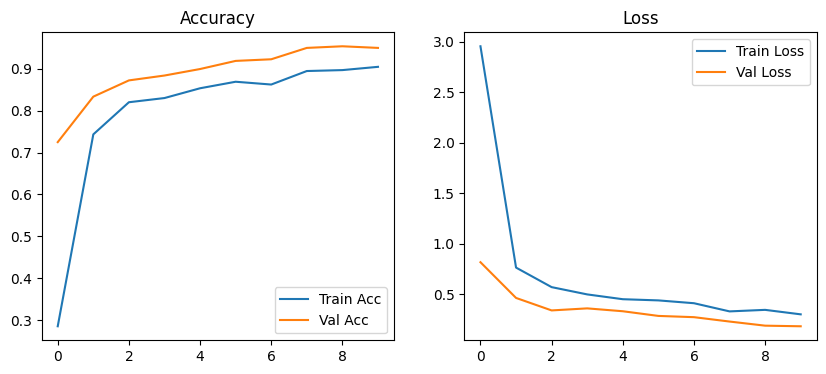

In [7]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['categorical_accuracy'], label='Train Acc')
plt.plot(history.history['val_categorical_accuracy'], label='Val Acc')
plt.title('Accuracy'); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss'); plt.legend()

plt.show()

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - categorical_accuracy: 0.8969 - loss: 0.3628
Test accuracy: 0.8984


### Results: Data Augmentation

- The graphs show that both training and validation accuracy rise quickly and stay close to around 0.9. The validation line is above the training line, which means the model generalizes well and is not overfitting.

- In the loss graph, the training loss is higher than the validation loss, which can happen when using dropout and data augmentation. These techniques add noise during training, making the validation performance appear slightly better.

Overall, data augmentation improved stability and generalization. The model became better at recognizing symbols in different positions and small rotations, showing strong and balanced performance.

-----

### Next steps

If we continue, maybe for the retake, we could add batch normalization and transfer learning.

-----

### References:
- https://www.youtube.com/watch?v=rfM4DaLTkMs&list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&index=17
- https://medium.com/@mehul.chourasia28/intro-to-data-augmentation-724bc4898585